# Implementing DoRA algorithm

## Creating LoRA and DoRA layers

We will be replacing the linear layers of the BERT model with the following DoRA and LoRA layers for our experiments

### LoRA Layer

In [2]:
import torch.nn as nn
import torch

class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

Below is the implementaion of the linear layer which will replace the ones in BERT

In [4]:
class LinearWithLoRA(nn.Module):

    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

### Implement DoRA Layer

The implementation of the DoRA layer solely adapts the LoRA layer to also include teh magnitude

In [ ]:
class LinearWithDoRAMerged(nn.Module):

    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )
        self.m = nn.Parameter(
            self.linear.weight.norm(p=2, dim=0, keepdim=True))


    def forward(self, x):
        lora = self.lora.A @ self.lora.B
        numerator = self.linear.weight + self.lora.alpha*lora.T
        denominator = numerator.norm(p=2, dim=0, keepdim=True)
        directional_component = numerator / denominator
        new_weight = self.m * directional_component
        return F.linear(x, new_weight, self.linear.bias)

# Training Experiments

### Load Data

#### Download IMDB training data and save to csv

In [ ]:
import os
from datasets import load_dataset

import pandas as pd
import torch

# Load the IMDB dataset
imdb_dataset = load_dataset("imdb")

# Split the existing 'train' split into a new 'train' (80%) and 'validation' (20%)
train_test_split = imdb_dataset["train"].train_test_split(test_size=0.2, seed=42)

final_train_data = train_test_split["train"]
final_val_data = train_test_split["test"]  
final_test_data = imdb_dataset["test"] 

# Define the directory to save the CSVs
output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

# Function to convert and save a split
def save_split_to_csv(dataset_split, name):
    # Convert Hugging Face Dataset to Pandas DataFrame
    df = pd.DataFrame(dataset_split)
    
    # Define the file path
    file_path = os.path.join(output_dir, f"{name}.csv")
    
    # Save the DataFrame to a CSV file
    df.to_csv(file_path, index=False)
    print(f"Successfully saved {name} data to: {file_path}")

# Save all three supervised splits
save_split_to_csv(final_train_data, "train")
save_split_to_csv(final_val_data, "validation")
save_split_to_csv(final_test_data, "test")


Successfully saved train data to: data\train.csv
Successfully saved validation data to: data\validation.csv
Successfully saved test data to: data\test.csv


#### Load data from csv files

In [17]:
import os
import pandas as pd
import torch

df_train = pd.read_csv(os.path.join("data", "train.csv"))
df_val = pd.read_csv(os.path.join("data", "validation.csv"))
df_test = pd.read_csv(os.path.join("data", "test.csv"))


train_texts = df_train['text']
train_labels = df_train['label']

val_texts = df_val['text']
val_labels = df_val['label']

test_texts = df_test['text']
test_labels = df_test['label']

#### Create tokenizer and Dataset Class

In [18]:
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorWithPadding, AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", clean_up_tokenization_spaces=True)

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, max_length=512, truncation=True, return_attention_mask=True, add_special_tokens=True) # Set smaller size (we know tweets are max 280 characters)
        item = {key: torch.tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item  


#### Load data into dataloaders

In [19]:
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # Dynamic padding of the input data for batching

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=data_collator, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=data_collator, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=data_collator, pin_memory=True)

## Train default BERT with various layer freezings

In [20]:
#define CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Function pre-requisites

Define function for freezing layers

In [21]:
# Freezing layers
def finetune_layers(model, layers):
    if layers == "classifier":
        # Freeze all layers except the classification layer
        for param in model.distilbert.parameters():
          param.requires_grad = False
        # Ensure the classification head remains trainable
        for param in model.classifier.parameters():
          param.requires_grad = True

    elif layers == "top_layers":
        # Fine-tuning only top layers of model
        # Freeze all DistilBERT layers
        for param in model.distilbert.parameters():
          param.requires_grad = False

        # Unfreeze the top 2 layers of DistilBERT
        for param in model.distilbert.transformer.layer[-2:].parameters():
          param.requires_grad = True

        # Ensure the classification head remains trainable
        for param in model.classifier.parameters():
          param.requires_grad = True

    elif layers == "none":
        # Do not freeze any layers
        pass

Define evaluation function

In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Define evaluation function
def evaluate(model, dataloader):
    model.eval()
    losses = []
    preds = []
    true_labels = []
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        losses.append(loss.item())
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())
    avg_loss = np.mean(losses)
    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')
    cm = confusion_matrix(true_labels, preds)
    cr = classification_report(true_labels, preds)
    return avg_loss, accuracy, f1, cm, cr

### Training with hyperparameter grid search

Set global variables to keep track of best model

In [131]:
# Initialize the best model and optimizer
best_val_loss_overall = float('inf')
best_val_accuracy_overall = 0

Set hyperparamters to be tested in grid search

In [132]:
# Define the sets of values for grid search
dropout_values = [0.1]  # Example values for dropout
batch_sizes = [32]  # Example values for batch size
learning_rates = [1e-5]  # Example values for learning rate
weight_decays = [0.01]  # Example values for weight decay
scheduler_names = ['cosine']  # Example values for scheduler name
num_epochs = 20

Set the number of parameters that will be fine-tuned

In [130]:
layers = "none"       # Freze layers -options: "classifier" (all layers frozen except classifier layers), 
                            #                        "top_layers" (top 2 layers unfrozen), 
                            #                        "none"       (no layers frozen)

Get the number of trainable parameters

In [ ]:
from transformers import AutoModelForSequenceClassification

# Get number of parameters

#Init Model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=2
)
finetune_layers(model, layers=layers)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

del model  # Delete the model to free up memory


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of trainable parameters: 66955010


#### Main training loop

In [135]:
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler
from tqdm import tqdm
import time


best_config = {'dropout': None, 'batch_size': None, 'lr': None, 'wd': None, 'scheduler': None}
patience = 2
epochs_ran = 0
model_saved_at_batch = 0
num_batches_best_model = 0
lrs_best_model = []
epoch_durations = []

# Loop through hyperparameters
for dropout in dropout_values:
    for batch_size in batch_sizes:
        for lr in learning_rates:
            for wd in weight_decays:
                for scheduler in scheduler_names:
                    print(f"Training with dropout={dropout} and batch_size={batch_size} and lr={lr} and wd={wd} and scheduler={scheduler}")
                    print(f"frozen layers: {layers}")
                    print(f"Current best loss: {best_val_loss_overall}")
                    print(f"Best current accuracy: {best_val_accuracy_overall}")
                    print("===============================================")



                    # Create DataLoaders with the current batch size
                    train_loader = DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn=data_collator,
                        pin_memory=True)


                    # Initialize the model with the current dropout value
                    model = AutoModelForSequenceClassification.from_pretrained(
                        "distilbert-base-uncased", num_labels=2, dropout=dropout
                    )
                    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
                    model.to(device)

                    # Layer freezing for fine tuning:                    
                    finetune_layers(model, layers=layers)

                    # Reset Patience counter and model accuracy tracker
                    patience_counter = 0
                    best_model_val_loss = float('inf')
                    best_model_val_accuracy = 0
                    model_train_accuracies = []
                    model_train_losses = []
                    val_accuracies = []
                    val_losses = []
                    lr_values = []
                    best_overall_model_found = False

                    # Initialize GradScaler for AMP
                    use_amp=True
                    scaler = torch.amp.GradScaler(device='cuda', enabled=use_amp)

                    # Initialize the optimizer and learning rate scheduler
                    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=wd,no_deprecation_warning=True)

                    num_training_steps = num_epochs * len(train_loader)
                    num_warmup_steps = int(0.1 * num_training_steps)
                    lr_scheduler = get_scheduler(
                        name=scheduler,
                        optimizer=optimizer,
                        num_warmup_steps=num_warmup_steps,
                        num_training_steps=num_training_steps
                    )

                    # Reset memory and synchronize CUDA
                    torch.cuda.empty_cache()
                    torch.cuda.reset_max_memory_allocated()
                    torch.cuda.synchronize()


                    # Start time measurement
                    training_start_time = time.time()
                    

                    # Train loop
                    for epoch in range(num_epochs):
                        epoch_start_time = time.time()
                        print(f"Epoch {epoch+1}/{num_epochs}")
                        model.train()
                        train_losses = []
                        train_preds = []
                        train_labels_epoch = []
                        progress_bar = tqdm(train_loader)
                        batch_accuracy = 0

                        for batch in progress_bar:
                            batch = {k: v.to(device) for k, v in batch.items()}

                            # Use autocast for mixed precision training
                            with torch.autocast(device_type=str(device), dtype=torch.float16, enabled=use_amp):
                                outputs = model(**batch)
                                loss = outputs.loss
                                logits = outputs.logits
                                train_losses.append(loss.item())
                                model_train_losses.append(loss.item())

                            # Backprop with GradScaler to scale gradients
                            scaler.scale(loss).backward()

                            # Update weights with scaler step
                            scaler.step(optimizer)
                            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                            scaler.update()  # Update the scaler for the next iteration

                            # Learning rate scheduler step
                            lr_scheduler.step()

                            # Get learning rate for the current batch
                            lr_values.append(optimizer.param_groups[0]['lr'])

                            optimizer.zero_grad(set_to_none=True) # set_to_none=True here can modestly improve performance

                            predictions = torch.argmax(logits, dim=-1)
                            train_preds.extend(predictions.cpu().numpy())
                            train_labels_epoch.extend(batch['labels'].cpu().numpy())

                           # Calculate accuracy for the current batch
                            correct_predictions = (predictions == batch['labels']).sum().item()
                            batch_accuracy = correct_predictions / len(batch['labels'])
                            model_train_accuracies.append(batch_accuracy)

                        # Measure epoch duration
                        epoch_end_time = time.time()
                        epoch_duration = epoch_end_time - epoch_start_time
                        epoch_durations.append(epoch_duration)
                        print(f"Epoch duration: {epoch_duration:.4f} seconds")                        
                        
                        # Measure Training performance for the epoch
                        avg_train_loss = np.mean(train_losses)
                        train_accuracy = accuracy_score(train_labels_epoch, train_preds)
                        train_f1 = f1_score(train_labels_epoch, train_preds)

                        # Evaluate the model on the validation set
                        val_loss, val_accuracy, val_f1, cm, cr = evaluate(model, val_loader)
                        val_accuracies.append(val_accuracy)
                        val_losses.append(val_loss)
                        print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}")
                        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
                        

                        # Update the best model if the current model is better
                        if val_loss < best_model_val_loss:
                            best_model_val_accuracy = val_accuracy
                            best_model_val_loss = val_loss
                            patience_counter = 0
                            if val_accuracy > best_val_accuracy_overall and val_loss < best_val_loss_overall:
                                best_val_loss_overall = val_loss
                                best_val_accuracy_overall = val_accuracy
                                model_saved_at_batch = (epoch+1)*len(train_loader)
                                num_batches_best_model = len(progress_bar)
                                best_config = {'dropout': dropout, 'batch_size': batch_size, 'lr': lr, 'wd': wd, 'scheduler': scheduler}
                                torch.save(model.state_dict(), f'best_model_DistilBERT_{layers}.pt')
                                print("===============================================")
                                print("NEW BEST MODEL FOUND")
                                print("===============================================")
                                best_overall_model_found = True

                        else:
                            patience_counter += 1
                            print(f"Patience counter: {patience_counter}")
                            if patience_counter >= patience:
                                if best_overall_model_found: # Save train accuracies and losses for the best model when early stopping
                                    best_model_training_accuracies = model_train_accuracies
                                    best_model_training_losses = model_train_losses
                                    best_model_val_accuracies = val_accuracies
                                    best_model_val_losses = val_losses
                                    best_model_epoch_durations = epoch_durations
                                    training_end_time = time.time()
                                    total_training_time = training_end_time - training_start_time
                                    epochs_ran = epoch
                                    lrs_best_model = lr_values
                                    print("Early stopping triggered.")
                                break
                        print("MODEL: -best loss:", best_model_val_loss, " -best accuracy:", best_model_val_accuracy)
                        print("OVERALL: -best loss:", best_val_loss_overall, " -best accuracy:", best_val_accuracy_overall)


                        # Save train accuracies and losses for the best model when all epochs are completed
                        if best_overall_model_found:                            
                            best_model_training_accuracies = model_train_accuracies
                            best_model_training_losses = model_train_losses
                            best_model_val_accuracies = val_accuracies
                            best_model_val_losses = val_losses
                            best_model_epoch_durations = epoch_durations
                            epochs_ran = epoch
                            lrs_best_model = lr_values
                            training_end_time = time.time()
                            total_training_time = training_end_time - training_start_time


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with dropout=0.1 and batch_size=32 and lr=1e-05 and wd=0.01 and scheduler=cosine
frozen layers: none
Current best loss: inf
Best current accuracy: 0


c:\Users\Admin\anaconda3\Lib\site-packages\torch\cuda\memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epoch 1/20


100%|██████████| 625/625 [02:01<00:00,  5.15it/s]


Epoch duration: 121.3682 seconds
Training Loss: 0.4832, Accuracy: 0.7320, F1 Score: 0.7171
Validation Loss: 0.2512, Accuracy: 0.8986, F1 Score: 0.8985
NEW BEST MODEL FOUND
MODEL: -best loss: 0.2511516793276936  -best accuracy: 0.8986
OVERALL: -best loss: 0.2511516793276936  -best accuracy: 0.8986
Epoch 2/20


100%|██████████| 625/625 [02:00<00:00,  5.17it/s]


Epoch duration: 120.8067 seconds
Training Loss: 0.2220, Accuracy: 0.9136, F1 Score: 0.9135
Validation Loss: 0.2123, Accuracy: 0.9102, F1 Score: 0.9102
NEW BEST MODEL FOUND
MODEL: -best loss: 0.21230624042475185  -best accuracy: 0.9102
OVERALL: -best loss: 0.21230624042475185  -best accuracy: 0.9102
Epoch 3/20


100%|██████████| 625/625 [01:58<00:00,  5.29it/s]


Epoch duration: 118.1170 seconds
Training Loss: 0.1687, Accuracy: 0.9379, F1 Score: 0.9379
Validation Loss: 0.2103, Accuracy: 0.9186, F1 Score: 0.9186
NEW BEST MODEL FOUND
MODEL: -best loss: 0.210304448726221  -best accuracy: 0.9186
OVERALL: -best loss: 0.210304448726221  -best accuracy: 0.9186
Epoch 4/20


100%|██████████| 625/625 [02:00<00:00,  5.20it/s]


Epoch duration: 120.0925 seconds
Training Loss: 0.1120, Accuracy: 0.9620, F1 Score: 0.9620
Validation Loss: 0.2139, Accuracy: 0.9216, F1 Score: 0.9216
Patience counter: 1
MODEL: -best loss: 0.210304448726221  -best accuracy: 0.9186
OVERALL: -best loss: 0.210304448726221  -best accuracy: 0.9186
Epoch 5/20


100%|██████████| 625/625 [01:56<00:00,  5.36it/s]


Epoch duration: 116.5760 seconds
Training Loss: 0.0716, Accuracy: 0.9780, F1 Score: 0.9781
Validation Loss: 0.2400, Accuracy: 0.9182, F1 Score: 0.9182
Patience counter: 2
Early stopping triggered.


Print final results and save to file

In [136]:
print(f"Best configuration for DistilBERT with layers {layers}")
print(f"Best configuration found: Dropout={best_config['dropout']}, Batch size={best_config['batch_size']}, Learning rate={best_config['lr']}, Weight decay={best_config['wd']}, Scheduler={best_config['scheduler']}")
print(f"Best validation accuracy: {best_val_accuracy_overall:.4f}")
print(f"Training duration: {total_training_time:.4f} seconds")
print(f"Average epoch durations: {np.mean(best_model_epoch_durations):.4f} seconds")

with open ('performances.txt', 'a') as f:
    f.write(f"Best configuration for DistilBERT with {layers}\n")
    f.write(f"Number of parameters: {num_params}\n")
    f.write(f"Best configuration found: Dropout={best_config['dropout']}, Batch size={best_config['batch_size']}, Learning rate={best_config['lr']}, Weight decay={best_config['wd']}, Scheduler={best_config['scheduler']}\n")
    f.write(f"Best validation accuracy: {best_val_accuracy_overall:.4f}\n")
    f.write(f"Best validation loss: {best_val_loss_overall:.4f}\n")
    f.write(f"Training duration: {total_training_time:.4f} seconds\n")
    f.write(f"Average epoch durations: {np.mean(best_model_epoch_durations):.4f} seconds\n")
    f.write("=============================================\n")

Best configuration for DistilBERT with layers none
Best configuration found: Dropout=0.1, Batch size=32, Learning rate=1e-05, Weight decay=0.01, Scheduler=cosine
Best validation accuracy: 0.9186
Training duration: 712.1629 seconds
Average epoch durations: 119.3921 seconds


#### Evaluate Best Model

In [137]:
# Re-initialise BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=2, 
    dropout=best_config['dropout']  
)
model.to(device)
finetune_layers(model, layers=layers)

# Load the best model weights
model.load_state_dict(torch.load(f'best_model_DistilBERT_{layers}.pt'))

# Evaluate the model on test set
test_loss, test_accuracy, test_f1, cm, cr = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}")

with open ('performances.txt', 'a') as f:
    f.write(f"Test performance for DistilBERT with layers {layers}\n")
    f.write(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}\n")
    f.write(f"\nConfusion Matrix:\n{cm}\n")
    f.write(f"\nClassification Report:\n{cr}\n")
    f.write("=============================================\n\n\n")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss: 0.2018, Accuracy: 0.9237, F1 Score: 0.9237


### Plot training accuracies and losses

Define smoothing funciton for better visualization using exponential moving average

In [138]:
def smooth_curve_ema (data, alpha): #Uses bias correction for increased accuracy of initial values
    smoothed_data = []
    V_n = 0  
    for n, Y_n in enumerate(data, 1): 
        V_n = alpha * Y_n + (1 - alpha) * V_n
        correction_factor = 1 - (1 - alpha)**n
        corrected_EMA = V_n / correction_factor
        smoothed_data.append(corrected_EMA)
    return smoothed_data

In [139]:
# Smoothing factor between 0 and 1 for EMA smoothing for acc and loss plots
alpha = 0.01

Plot training and validation accuracy

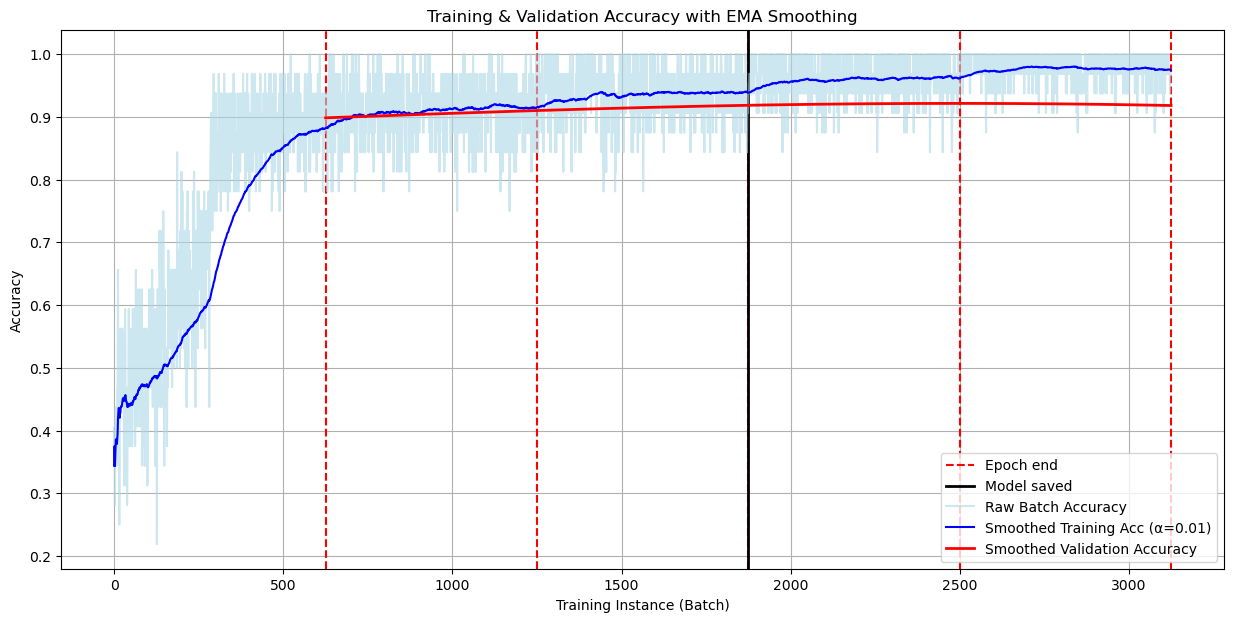

In [140]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, interp1d

plt.figure(figsize=(15, 7))

#------------- Plot where epochs end -------------#
for i in range(1, epochs_ran + 2):
    if i == 1:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--', label='Epoch end')
    else:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--')
plt.axvline(x=model_saved_at_batch, color='black', label='Model saved', linewidth=2) # Plot where the model was saved


#------------- Plot the training accuracies ------------#
plt.plot(best_model_training_accuracies, 
         label='Raw Batch Accuracy', 
         color='lightblue', 
         alpha=0.6) # Reduced opacity for the background noise

#Plot smoothed training accuracies
smoothed_accuracies = smooth_curve_ema(best_model_training_accuracies, alpha)
plt.plot(smoothed_accuracies, 
         label=f'Smoothed Training Acc (α={alpha})', 
         color='blue', 
         linewidth=1.5)


#------------ Plot validation accuracies --------------#
val_x = np.array([i * num_batches_best_model for i in range(1, epochs_ran + 2)]) 
val_y = np.array(best_model_val_accuracies)

# Interpolate some points for a smooth curve for validation acc, currently we only have one measure per epoch
val_x_smooth = np.linspace(val_x.min(), val_x.max(), 300) # Create 300 new points
interp_func = interp1d(val_x, val_y, kind='cubic') # Use cubic for a smooth fit
val_y_smooth = interp_func(val_x_smooth)

plt.plot(val_x_smooth, 
         val_y_smooth, 
         color='red', 
         label='Smoothed Validation Accuracy', 
         linewidth=2)


# ------------- Finalize plot and save plot --------------#
plt.xlabel(f'Training Instance (Batch)')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy with EMA Smoothing')
plt.legend()
plt.grid(True)
plt.savefig(f'acc_for_best_model_{layers}.png')
plt.show()

Plot Training and Validation Loss

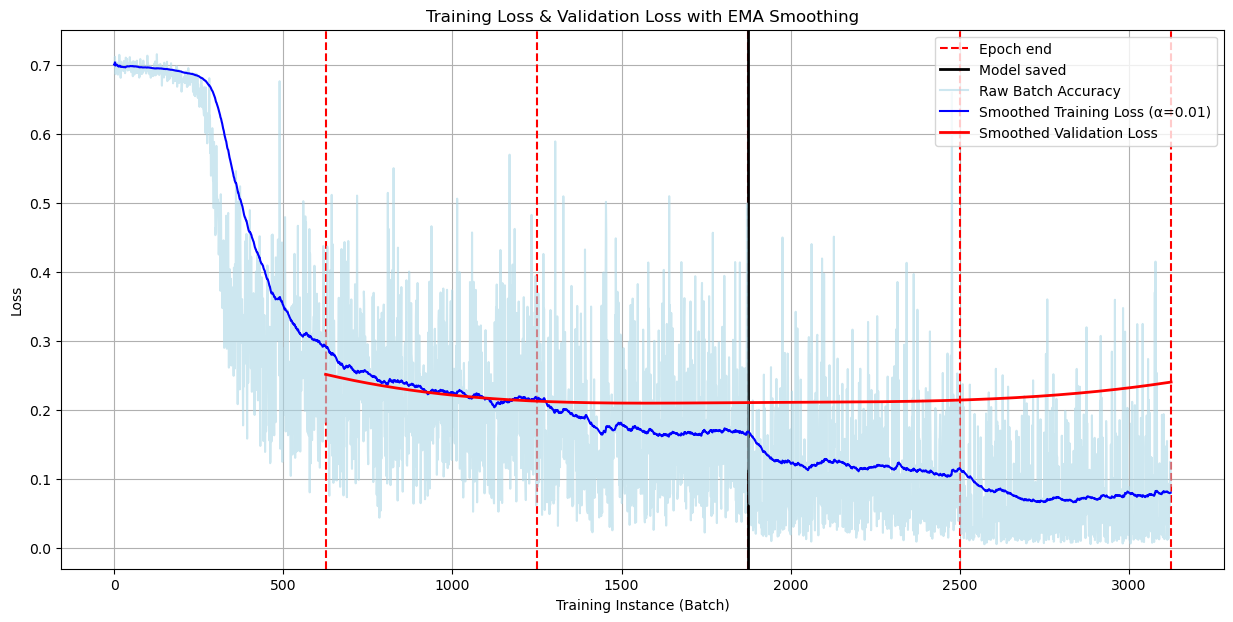

In [141]:
plt.figure(figsize=(15, 7))

#------------- Plot where epochs end -------------#
for i in range(1, epochs_ran + 2):
    if i == 1:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--', label='Epoch end')
    else:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--')
plt.axvline(x=model_saved_at_batch, color='black', label='Model saved', linewidth=2) # Plot where the model was saved


#------------ Plot the training losses -------------#
plt.plot(best_model_training_losses, 
         label='Raw Batch Accuracy', 
         color='lightblue', 
         alpha=0.6) # Reduced opacity for the background noise

#Plot smoothed training losses
smoothed_losses = smooth_curve_ema(best_model_training_losses, alpha)
plt.plot(smoothed_losses, 
         label=f'Smoothed Training Loss (α={alpha})', 
         color='blue', 
         linewidth=1.5)


#------------- Plot validation losses --------------#
loss_x = np.array([i * num_batches_best_model for i in range(1, epochs_ran + 2)])
loss_y = np.array(best_model_val_losses)

# Interpolate some points for a smooth curve for validation loss, currently we only have one measure per epoch
loss_x_smooth = np.linspace(loss_x.min(), loss_x.max(), 300) #
interp_func_loss = interp1d(loss_x, loss_y, kind='cubic') # Use cubic for a smooth fit
loss_y_smooth = interp_func_loss(loss_x_smooth)

plt.plot(loss_x_smooth, 
         loss_y_smooth, 
         color='red', 
         label='Smoothed Validation Loss', 
         linewidth=2)


# ------------- Finalize plot and save plot --------------#
plt.xlabel(f'Training Instance (Batch)')
plt.ylabel('Loss')
plt.title('Training Loss & Validation Loss with EMA Smoothing')
plt.legend()
plt.grid(True)
plt.savefig(f'loss_for_best_model_{layers}.png')
plt.show()


Plot merged accuracy and losses (smnoothed)

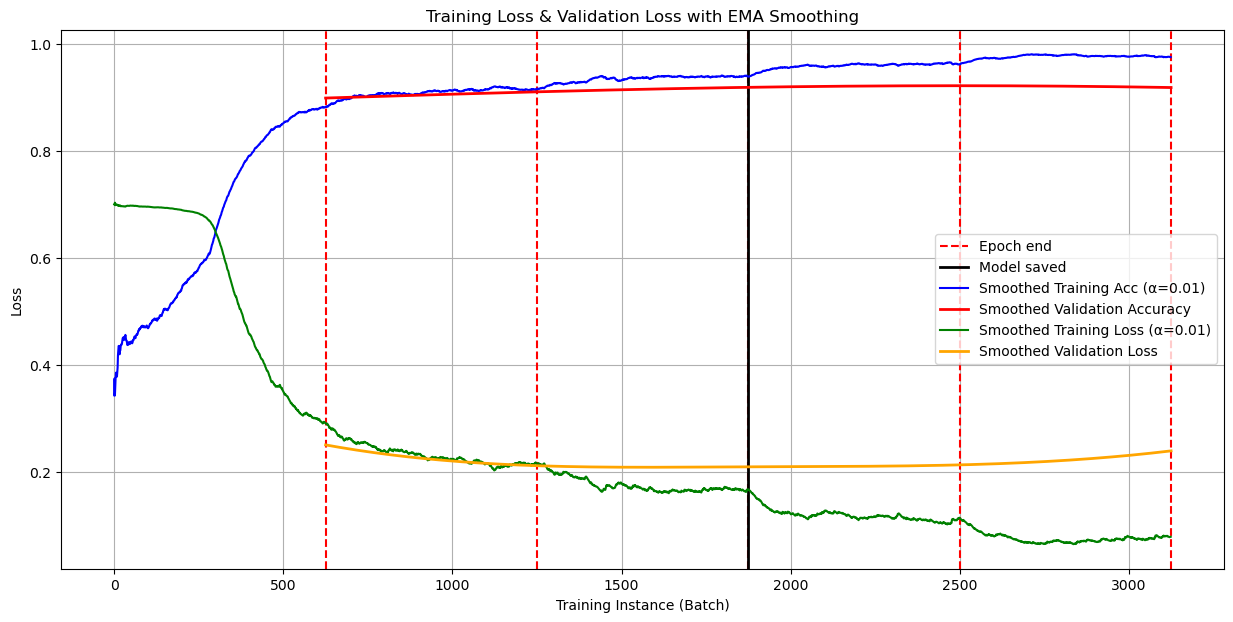

In [142]:
plt.figure(figsize=(15, 7))

#------------- Plot where epochs end -------------#
for i in range(1, epochs_ran + 2):
    if i == 1:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--', label='Epoch end')
    else:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--')
plt.axvline(x=model_saved_at_batch, color='black', label='Model saved', linewidth=2) # Plot where the model was saved


#------------- Plot the smoothed accuracies ------------#
smoothed_accuracies = smooth_curve_ema(best_model_training_accuracies, alpha)
plt.plot(smoothed_accuracies, 
         label=f'Smoothed Training Acc (α={alpha})', 
         color='blue', 
         linewidth=1.5)


#------------ Plot validation accuracies --------------#
val_x = np.array([i * num_batches_best_model for i in range(1, epochs_ran + 2)]) 
val_y = np.array(best_model_val_accuracies)

# Interpolate some points for a smooth curve for validation acc, currently we only have one measure per epoch
val_x_smooth = np.linspace(val_x.min(), val_x.max(), 300) # Create 300 new points
interp_func = interp1d(val_x, val_y, kind='cubic') # Use cubic for a smooth fit
val_y_smooth = interp_func(val_x_smooth)

plt.plot(val_x_smooth, 
         val_y_smooth, 
         color='red', 
         label='Smoothed Validation Accuracy', 
         linewidth=2)


#-------------- Plot smoothed losses -------------#
smoothed_losses = smooth_curve_ema(best_model_training_losses, alpha)
plt.plot(smoothed_losses, 
         label=f'Smoothed Training Loss (α={alpha})', 
         color='green', 
         linewidth=1.5)


#------------- Plot validation losses --------------#
loss_x = np.array([i * num_batches_best_model for i in range(1, epochs_ran + 2)])
loss_y = np.array(best_model_val_losses)

# Interpolate some points for a smooth curve for validation loss, currently we only have one measure per epoch
loss_x_smooth = np.linspace(loss_x.min(), loss_x.max(), 300) #
interp_func_loss = interp1d(loss_x, loss_y, kind='cubic') # Use cubic for a smooth fit
loss_y_smooth = interp_func_loss(loss_x_smooth)

plt.plot(loss_x_smooth, 
         loss_y_smooth, 
         color='orange', 
         label='Smoothed Validation Loss', 
         linewidth=2)


# ------------- Finalize plot and save plot --------------#
plt.xlabel(f'Training Instance (Batch)')
plt.ylabel('Loss')
plt.title('Training Loss & Validation Loss with EMA Smoothing')
plt.legend()
plt.grid(True)
plt.savefig(f'acc_loss_for_best_model_{layers}.png')
plt.show()
